# 1. Question Formulation  

`Introduce the goal of your analysis. What questions will you seek to answer, why do people perform this kind of analysis on this kind of data? Preview what level of performance your model would need to achieve to be practically useful.`

The ultimate goal of this analysis is to predict click-through rates for online advertising for Criteo by generating individual click-through predictions for different user/ad/context combinations. Criteo is an advertising technology company that offers a variety of solutions for helping e-commerce companies understand and serve targeted ads to their customers. 

The formula for click-through rate is (Total Clicks on Ad) / (Total Times Users Saw the Add). Click through rates are useful to companies in several ways:
1. E-commerce sites or advertising companies could compare the click rate of one ad to another to determine which one is doing better, and use that information to make adjustments to what ads they are serving. 
2. E-commerce sites could use click-through rates as part of their projections for web traffic and sales.
3. Platforms that serve ads, like Google, have a vested interest in serving users ads that are relevant to them, so they will offer discounts to advertisers on ads that have a high click through rate, as well as other desirable qualities.

Criteo formulated the question this way for the Kaggle competition using this data set: "Given a user and the page he is visiting, what is the probability that he will click on a given ad?"  `By predicting probability of click for particular user/ad/context combinations, we aren't directly predicting click through rate, but rather predicting the elements we will use to calculate click through rate.` By making predictions on the test set, and taking the N prediction rows that correspond to a particular prediction, and the C positive examples where our model predicts that the user would click, we can say, "if we showed users this ad N times, we predict that the click through rate would be C/N."

The train and test data sets for this problem have 40 columns:
- a label column, with a 1 or 0 indicating that the user did or did not click through the ad, respectively
- 13 columns with numerical data
- 26 columns with categorical data, where all categorical values are hexified for confidentiality
Since we have no column labels and no insight into the categories in the categorical feature columns, we are limited in the number of questions we can answer. We can't calculate and compare the click-through rates of different ads or different ad contexts, or compare the click-through rates for different users, without knowing which columns refer to users, ads, or different elements of context. 

As a result, the only click-through rate we can calculate is one for the entire data set. We can make a prediction for each individual row of data (representing a user, ad, and context), and then we can calculate a click-through rate for the entire set of predictions. Without knowing anything about the data (is it all for one advertiser? for one advertising campaign? for ads displayed on a single website?), it's hard to know what question the click through rate will help us answer. We could answer "what is the baseline click-through rate for this set of data," or perhaps, if we explore feature importance in our final model, "which features are most useful for predicting click-through rate on this data"?

TODO: clarify what question we're answering above, and introduce what algorithm we will use

# 2. Algorithm Explanation 

`Create your own toy example that matches the dataset provided and use this toy example to explain the math behind the algorithm that you will perform.`

In [ ]:
# answer #2 in this section
# STEVE

For this project, we have built a Factorization Machine algorithm `from the ground up` *(from first principles?)*, and applied it to a small sample dataset.  For the full dataset, we have implemented a Logistic Regression algorithm utilizing the Spark ML library.

The Factorization Machine algorithm that we built was based on two papers by Steffen Rendle:
1. Factorization Machines (Data Mining (ICDM), 2010 IEEE 10th International Conference on. (2010) 995–1000,  
https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf), and  
2. Factorization Machines with libFM (ACM Transactions on Intelligent Systems and Technology, Vol. 3, No. 3, Article 57, Publication date: May 2012., https://www.csie.ntu.edu.tw/~b97053/paper/Factorization%20Machines%20with%20libFM.pdf).  
The second Rendle paper was particularly helpful for algorithm explanation, and to guide implementation of the FM algorithm.

Equation 1 shows the basic relationship between the predicted target variable $\hat{y}$ and the independent variables in the second-order Factorization Machine model. 


\begin{equation} \tag{1}
\hat{y}(\boldsymbol{x}) = w_0 + \sum_{j=1}^{p}w_j x_j + \sum_{j=1}^{p} \sum_{j'=j+1}^{p}x_j x_j' \sum_{f=1}^{k}v_{j,f} v_{j',f}  
\end{equation}

where $\boldsymbol{x} \in \mathbb{R} ^{p}$ is a feature vector with $p$ real-valued variables.  Here $k$ is the dimensionality of the factorization, also known as the number of latent factors, and the model parameters are 

\begin{equation} \tag{2}
w_0 \in \mathbb{R}, \space\space\space  \boldsymbol{w} \in \mathbb{R}^p,  \space\space\space  V \in \mathbb{R}^{p \times k} 
\end{equation}



The total number of parameters in the FM model is $|\Theta| =  1 + p + p \times k$, with $k \ll p$.  The first part of the FM model in eq. 1 is the same as a standard regression model, in that we have the bias $w_0$ and the linear terms $w_j x_j$.  The second part of the FM equation captures the second-order (pair-wise) interactions between the independent variables, $x_j x_{j'}$.  An important distinction here is that, in contrast to standard polynomial regression, the coefficients for the interaction terms are not independent parameters $w_j$, but rather a factorized parameterization of $w_{j,j} \approx \sum_{f=1}^{k}v_{j,f} v_{j',f}$, which is shown in the last summation in eq. 1.  This reflects the assumption that $w_{j,j}$ can be approximated by low-rank matrices.  This allows FMs to estimate the interaction parameters reliabily, even in the presence of highly sparse data where standard models fail.

Our approach in the home-grown algorithm is to include all these terms in the model.  In contrast, standard Alternating Least Squares (ALS) algorithm uses only the interaction terms, without the linear terms.  Also, standard regression models often omit interaction terms.  The more ideal approach is to retain the linear terms and the interaction terms, as we have implemented for a small sample from our dataset.  

Our training task is to find that optimal model parameters $\Theta$ such that we minimize the sum of the losses over the observed data $S$, given the appropriate loss function $L$.  This takes the general form:

\begin{equation} \tag{3}
OptReg(S,\lambda) = argmin_{\theta} \bigg( \sum_{(\boldsymbol{x},y)\in S}L(\hat{y}(\boldsymbol{x}|\Theta,y) + Reg_{\lambda_{\theta}} \bigg) 
\end{equation}

where $Reg$ contains the regularization penalty.  

For the Spark ML Logistic Regression model, we use both $L_2$ regularization:

\begin{equation} \tag{4}
Reg_{L_2} = \sum_{\theta \in \Theta} \lambda_{\theta} \theta^2  
\end{equation}

and ElasticNet Regularization (https://spark.apache.org/docs/1.5.2/ml-linear-methods.html), which is a combination of $L_1$ and $L_2$ regularization:

\begin{equation} \tag{5}
Reg_{EN} = \alpha \big( \lambda \| \boldsymbol{w} \|_1 \big) + (1 - \alpha) \space \big( \frac{\lambda}{2} \| \boldsymbol{w} \|_{2}^{2} \big)  
\end{equation}

where $\alpha \in [0,1]$ and $ \lambda \geq 0$.  

For the home-grown model in this project, we do not include regularization terms.  

With this binary classification problem, with $y \in$ {0,1}, we leverage Andrew Ng's treatment (https://www.youtube.com/watch?v=TTdcc21Ko9A&feature=youtu.be) of the log loss function, $L$:

\begin{equation} \tag{6}
L(\theta) = - \frac{1}{m} \sum_{i=1}^{m} \bigg( y^{(i)} log \space h_{\theta}(x^{(i)}) + (1-y^{(i)}) log \big( 1-h_{\theta}(x^{(i)}) \big)  \bigg) 
\end{equation}

where $m$ is the number of training examples, and $h_{\theta}(x)$ is the sigmoid function when using logistic regression,

\begin{equation} \tag{7}
h_{\theta}(x) = \frac{1}{1 + \exp({-\theta^{T} x})} 
\end{equation}

For the home-grown model, we use full-batch Gradient Descent applied to the convex loss function $L$ to converge on the global minimum in model parameter space.  The gradient is computed:

\begin{equation} \tag{8}
\frac{\partial}{\partial \theta_j} L(\theta) = - \frac{1}{m} \sum_{i=1}^{m} \big( h_{\theta}(x^{(i)}) - y^{(i)} \big) \frac{\partial \hat{y}(x)}{\partial \theta}
\end{equation}

where  

\begin{equation} \tag{9}
 \frac {\partial \hat{y}(\boldsymbol{x})} {\partial \theta} = 
  \begin{cases} 
   1,      & \text{if } \theta \text{ is } w_0 \\
   x_l,      & \text{if } \theta \text{ is } w_l \\
   x_l\sum_{j\neq l} v_{j,f}x_j,  & \text{if } \theta \text{ is } v_{l,f} 
  \end{cases}
\end{equation}


We the repeat the gradient descent updates until the stopping condition is met:

\begin{equation} \tag{10}
\theta_{j} \longleftarrow \theta_j - \eta \frac{\partial}{\partial \theta_j} L(\theta)
\end{equation}

where $\eta$ is the learning rate.  

For the home-grown model, we use $\eta = 0.01$ and 10 latent factors ($k=10$).  We initialize the model parameters $w_0$ and $\boldsymbol{w}$ to 0.0, and $V$ to a random normal distribution with mean = 0 and std = 0.01.   We iterate for a specified number of training iterations (default = 10). 

References for binary classification:....  
https://www.youtube.com/watch?v=TTdcc21Ko9A&feature=youtu.be  
https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html  
https://spark.apache.org/docs/1.5.2/ml-linear-methods.html  

# 3. EDA & Discussion of Challenges  

Determine 2-3 relevant EDA tasks that will help you make decisions about how you implement the algorithm to be scalable. Discuss any challenges that you anticipate based on the EDA you perform.

In [1]:
# answer #3 in this section
# Alex
#   - explore log transforming a selected set of features (Saturday)

## Setup

In [1]:
import time
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pprint import pprint
from pyspark.sql import types, Row, Column
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, VectorIndexer
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel, RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# from pyspark.ml import Pipeline
# import ast
# import re


In [2]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "finalProject"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

quick check on the size of our dataset

In [3]:
!wc -l data/train.txt
!wc -l data/test.txt

45840617 data/train.txt
6042135 data/test.txt


## EDA

First we will read in our dataset and check the structure

In [3]:
train = spark.read.parquet('data/train.parquet')

**REMOVE THIS PRIOR TO SUBMISSION**

In [4]:
train = train.sample(False, 0.0001)

In [6]:
trainRdd = train.rdd
trainRdd.count()

45815

In [9]:
N = train.count()
N

45805

In [10]:
train.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = tru

From the `README` we know that the first column is the label, columns 2-13 are numerical columns and columns 14-39 are categorical. We will rename these columns so that we can distinguish between label, numerical data, and categorical data

In [5]:
def renameCols(df, trainingSet=True):
    
    # rename label column
    df = df.withColumnRenamed('_c0', 'label')
    numericalCols = [c for c in df.columns[1:14]]
    categoricalCols = [c for c in df.columns[14:]]

    # rename numerical columns
    for i,c in enumerate(numericalCols):
        newName = 'n' + str(i)
        df = df.withColumnRenamed(c, newName)
    
    # rename categorical columns
    for i,c in enumerate(categoricalCols):
        newName = 'c' + str(i)
        df = df.withColumnRenamed(c, newName)
        
    return df

In [6]:
train = renameCols(train)

In [7]:
print(train.columns)

['label', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25']


The numerical columns are currently strings and will be easier to work with for mathematical manipulation if they are cast as type `float`

In [8]:
def castNumericalAsFloat(df):
    numericalCols = [c for c in df.columns if 'n' in c or 'label' in c]
    for c in numericalCols:
        df = df.withColumn(c, df[c].cast('float'))
        
    return df

In [9]:
train = castNumericalAsFloat(train)

In [10]:
train.printSchema()

root
 |-- label: float (nullable = true)
 |-- n0: float (nullable = true)
 |-- n1: float (nullable = true)
 |-- n2: float (nullable = true)
 |-- n3: float (nullable = true)
 |-- n4: float (nullable = true)
 |-- n5: float (nullable = true)
 |-- n6: float (nullable = true)
 |-- n7: float (nullable = true)
 |-- n8: float (nullable = true)
 |-- n9: float (nullable = true)
 |-- n10: float (nullable = true)
 |-- n11: float (nullable = true)
 |-- n12: float (nullable = true)
 |-- c0: string (nullable = true)
 |-- c1: string (nullable = true)
 |-- c2: string (nullable = true)
 |-- c3: string (nullable = true)
 |-- c4: string (nullable = true)
 |-- c5: string (nullable = true)
 |-- c6: string (nullable = true)
 |-- c7: string (nullable = true)
 |-- c8: string (nullable = true)
 |-- c9: string (nullable = true)
 |-- c10: string (nullable = true)
 |-- c11: string (nullable = true)
 |-- c12: string (nullable = true)
 |-- c13: string (nullable = true)
 |-- c14: string (nullable = true)
 |-- c15: st

Let's examine the distribution of labels so that we account for any label bias in our model

In [13]:
labelCounts = train.groupBy('label').count().collect()

In [14]:
print('number of clicks: ', labelCounts[0]['count'])
print('number of non-clicks: ', labelCounts[1]['count'])
print("{:.2f}% clicks, {:.2f}% non-clicks".format((labelCounts[0]['count'] / N) * 100, (labelCounts[1]['count'] / N) * 100))

number of clicks:  1179
number of non-clicks:  3310
26.26% clicks, 73.74% non-clicks


## Examining numerical data

We want to start by examining some basic statistics on the numerical data. This allows us to understand the number of missing values we are working with and get a sense of the distribution of each variable (which we will explore further later on in this section)

In [15]:
# full training set
start = time.time()
stats = train[train.columns[1:14]].describe()
means = np.array(stats[stats['summary'] == 'mean'].collect())[0][1:]
stdevs = np.array(stats[stats['summary'] == 'stddev'].collect())[0][1:]
print('runtime (min): ', (time.time() - start) / 60)

runtime (min):  0.31729697783788047


In [16]:
stats.show(vertical=True)

-RECORD 0---------------------
 summary | count              
 n0      | 2498               
 n1      | 4489               
 n2      | 3555               
 n3      | 3538               
 n4      | 4382               
 n5      | 3529               
 n6      | 4301               
 n7      | 4488               
 n8      | 4301               
 n9      | 2498               
 n10     | 4301               
 n11     | 1074               
 n12     | 3538               
-RECORD 1---------------------
 summary | mean               
 n0      | 3.379503602882306  
 n1      | 102.88505235018935 
 n2      | 24.09226441631505  
 n3      | 7.46184284906727   
 n4      | 17021.091510725695 
 n5      | 115.81127798243128 
 n6      | 15.580097651708904 
 n7      | 12.663101604278076 
 n8      | 100.17484305975354 
 n9      | 0.6253002401921537 
 n10     | 2.713322483143455  
 n11     | 1.0707635009310987 
 n12     | 8.241944601469758  
-RECORD 2---------------------
 summary | stddev             
 n0     

With such a large dataset, it is also importatnt to check the sparsity of the dataset (how many missing values are we working with). This will inform our decisions of how to handle missing data during our feature engineering. We can infer this answer from the `count` data above, but for clarity we will calculate it explicitly.

In [17]:
numericNans = {}
for c in stats.columns[1:]:
    numericNans[c] = N - int(stats.select(c).collect()[0][0])
print('missing numeric values\n')
pprint(numericNans)

missing numeric values

{'n0': 1991,
 'n1': 0,
 'n10': 188,
 'n11': 3415,
 'n12': 951,
 'n2': 934,
 'n3': 951,
 'n4': 107,
 'n5': 960,
 'n6': 188,
 'n7': 1,
 'n8': 188,
 'n9': 1991}


We see we have a wide range of values in the numerical data. Column `n4` ranges from 0-2e7 whereas column `n9` ranges from 0-11.  this indicates that the numerical data will need normalization during our feature engineering steps. 

We can also see we have a large amount of missing values and the number each column is missing varies. Column `n1` is not missing any values, but column `n0` and `n9` are missing nearly half the data and column `n11` is missing over 75% of the total rows. Our model choice of **ENTER MODEL NAME HERE** influences how we handle these missing values. Our model of Logistic Regression and Factorization Machine receives the features in a single numerical vector format, so during the feature engineering, the missing numerical values will need to be converted to numerical values, likely 0's. 

Before we move on to examining the categorical data, we first want to dig into the numerical data a bit further. We will take a small sample to examine the data further.

In [15]:
s = train.sample(False, 0.001)
s.count()

45802

In [16]:
df = s.toPandas()

In [17]:
df.iloc[:,1:14].head()

,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12
0,NaN,1.0,4.0,1.0,25090.0,349.0,1.0,1.0,13.0,NaN,1.0,0.0,1.0
1,NaN,-1.0,NaN,NaN,21684.0,NaN,0.0,0.0,41.0,NaN,0.0,NaN,NaN
2,6.0,6.0,5.0,NaN,803.0,5.0,7.0,4.0,4.0,1.0,2.0,NaN,NaN
3,NaN,-1.0,NaN,NaN,23546.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,1.0,48.0,21.0,7.0,8.0,6.0,1.0,7.0,7.0,1.0,1.0,NaN,4.0


We first want to examine if any of our variables already appear to be strong indicators of clicks. If we see certain columns that more often correspond to clicks, we may need to apply some variable weighting in our model. We can look at the total number of counts per clicks for each numerical variable

Text(0.5,1,'Total Counts per Label')

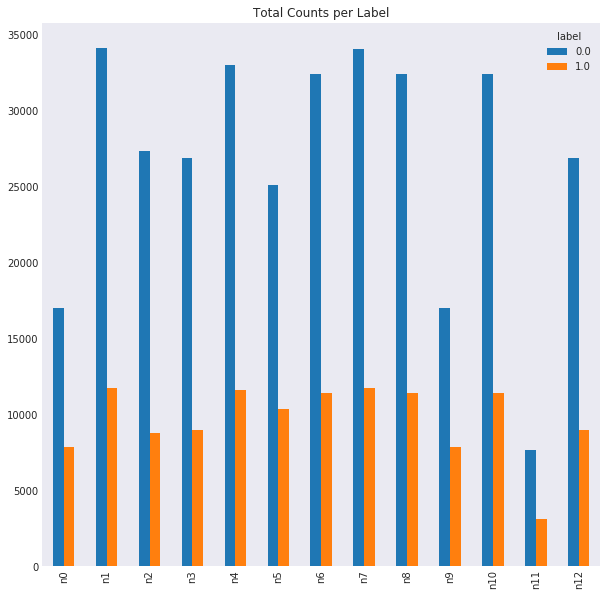

In [18]:
countByLabel = df.groupby(df.columns[0]).count()
countByLabel.iloc[:,:13].transpose().plot(kind='bar', figsize=(10,10))
plt.title('Total Counts per Label')

So there doesn't seem to be much of a trend with any particular column. Most columns show roughly 65-75% of non-clicks for our sample which is right in line with the population distribution.

Since we have such a large feature space already, we want to determine if we can reduce the number of numerical columns. If certain numerical variables are correlated with each other, we might be able to combine these columns or simply drop one or the other. We will examine a correlation matrix to make this determination

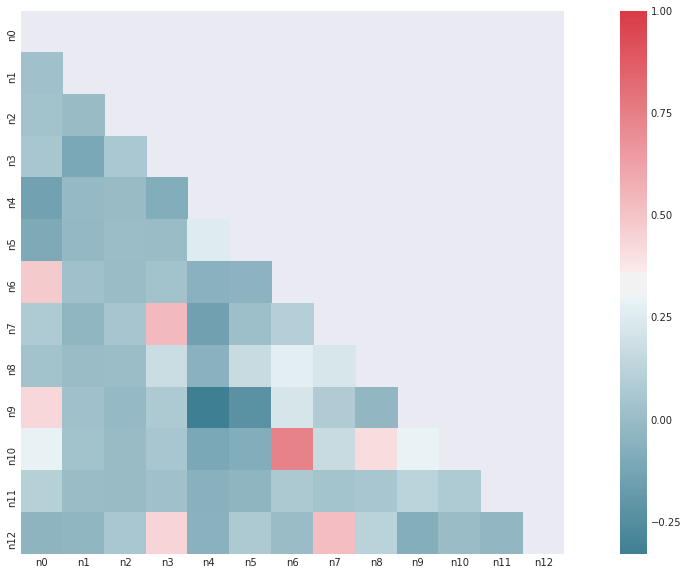

In [28]:
corr = df.iloc[:,1:14].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, square=True)

We see that we have little to no correlation in our numeric variables. It appears that `n6` and `n10` are the most strongly positively correlated, but they only have a correlation coefficient of ~0.6. If we were going to be using this data for inference (as we might if we were designing the ad that we were trying to get clicks on) then we may consider keeping only one of these variables so as to avoid multicollinearity in our model. Since we only care about predictive power, we will leave these variables as they are in our model. 

The last thing we want to look at in our numerical columns is the distribution of values. We saw we had a wide range of values in the basic statistics and this indicates that we might have considerable skew in our variables. We will examine the histograms each numerical variable

In [41]:
def plotHistograms(df):
    # set up the subplot figure
    dim = np.ceil(np.sqrt(len(df.columns[1:14])))
    fig = plt.figure(figsize=(6,4))
    fig.subplots_adjust(left=0, right=2, bottom=0, top=2.5)
    for i,c in enumerate(df.columns[1:14]):
        # for each numerical variable, plot a histogram of non-missing values
        ax = fig.add_subplot(dim, dim, i + 1)
        ax.hist(df[c].dropna(), bins=50)
        ax.set_title(df.columns[i + 1])

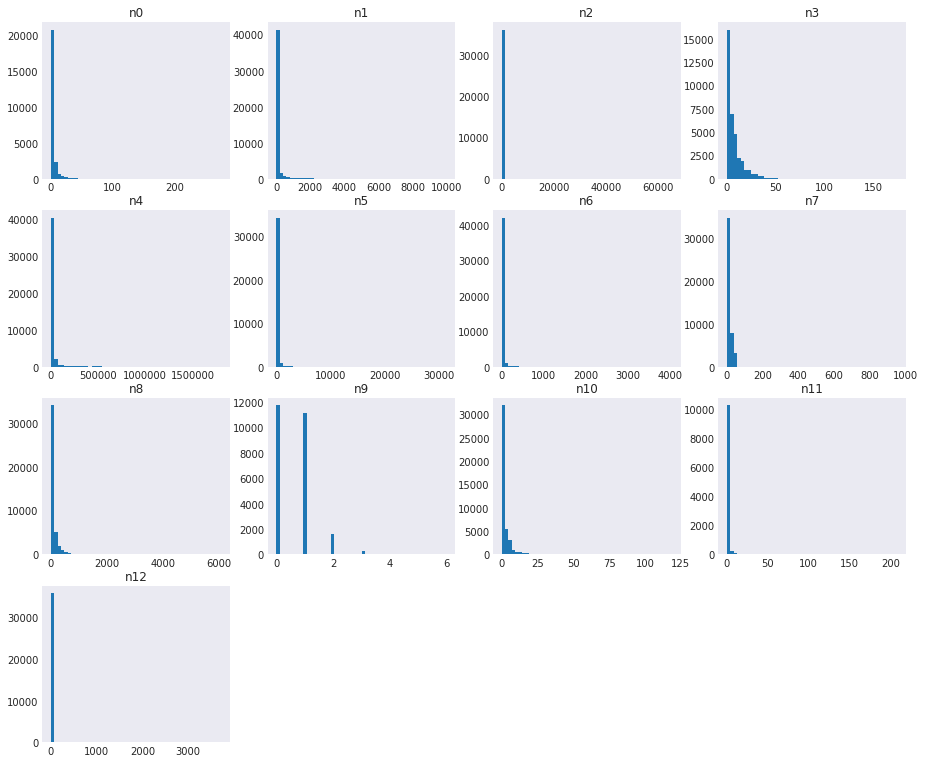

In [42]:
plotHistograms(df)

We see from the histogram that we have pretty extreme skew in all our numeric variables. This indicates we may want to consider applying a log transform to help these distributions appear more normal.

In [43]:
def plotHistogramsWithLogTransformation(df):
    # set up the subplots figure
    dim = np.ceil(np.sqrt(len(df.columns[1:14])))
    fig = plt.figure(figsize=(6,4))
    fig.subplots_adjust(left=0, right=2, bottom=0, top=2.5)
    for i, col in enumerate(df.columns[1:14]):
        # add the subplot
        ax = fig.add_subplot(dim, dim, i + 1)
        
        # replace the missing values with 0
        c = df[col].copy()
        c.fillna(0, inplace=True)
        
        # take natural log of nonzero values (to avoid -inf)
        c[c != 0] = c[c != 0].apply(np.log)
        
        # plot histogram
        ax.hist(c.dropna(), bins=50)
        ax.set_title(df.columns[i + 1])

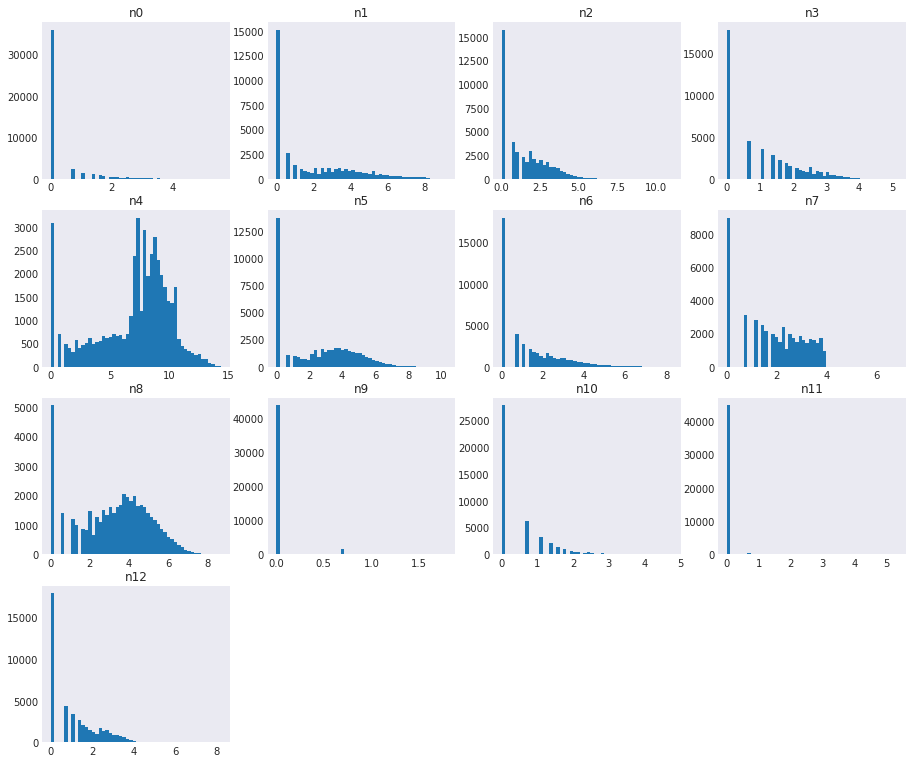

In [44]:
plotHistogramsWithLogTransformation(df)

The log transformation clearly improves many of the distributions, giving more meaning to each unique value in those columns. We will want to apply a log transformation during our feature engineering phase

## Examine Categorical variables

We can now start to examine the categorical data. In order to understand the size of our feature space, we need to understand the number of unique features (classes) in each categorical variable. Let's look at the total counts, the number of missing values, and the number of the unique classes from each category

In [45]:
categoricalCounts = train[train.columns[14:]].summary('count')

In [46]:
categoricalCounts.show(vertical=True)

-RECORD 0-----------
 summary | count    
 c0      | 45840617 
 c1      | 45840617 
 c2      | 44281144 
 c3      | 44281144 
 c4      | 45840617 
 c5      | 40299992 
 c6      | 45840617 
 c7      | 45840617 
 c8      | 45840617 
 c9      | 45840617 
 c10     | 45840617 
 c11     | 44281144 
 c12     | 45840617 
 c13     | 45840617 
 c14     | 45840617 
 c15     | 44281144 
 c16     | 45840617 
 c17     | 45840617 
 c18     | 25667759 
 c19     | 25667759 
 c20     | 44281144 
 c21     | 10885544 
 c22     | 45840617 
 c23     | 44281144 
 c24     | 25667759 
 c25     | 25667759 



In [47]:
categoricalNulls = {}
for c in categoricalCounts.columns[1:]:
    categoricalNulls[c] = N - int(categoricalCounts.select(c).collect()[0][0])
print('missing categorical values\n')
pprint(categoricalNulls)

missing categorical values

{'c0': 0,
 'c1': 0,
 'c10': 0,
 'c11': 1559473,
 'c12': 0,
 'c13': 0,
 'c14': 0,
 'c15': 1559473,
 'c16': 0,
 'c17': 0,
 'c18': 20172858,
 'c19': 20172858,
 'c2': 1559473,
 'c20': 1559473,
 'c21': 34955073,
 'c22': 0,
 'c23': 1559473,
 'c24': 20172858,
 'c25': 20172858,
 'c3': 1559473,
 'c4': 0,
 'c5': 5540625,
 'c6': 0,
 'c7': 0,
 'c8': 0,
 'c9': 0}


So many of our categorical columns are not missing any data, but some are missing huge amounts of data. This could be a problem for our feature space. We will need to decide if `null` should be considered a unique class or not for each category. Now we want to examine the total number of unique classes in each category and our dataset as a whole

In [48]:
uniqueCounts = {}
for c in train.columns[14:]:
    count = train.agg(F.countDistinct(c).alias('c')).collect()[0]['c']
    uniqueCounts[c] = count

In [49]:
uniqueCounts

{'c0': 1460,
 'c1': 583,
 'c2': 10131226,
 'c3': 2202607,
 'c4': 305,
 'c5': 23,
 'c6': 12517,
 'c7': 633,
 'c8': 3,
 'c9': 93145,
 'c10': 5683,
 'c11': 8351592,
 'c12': 3194,
 'c13': 27,
 'c14': 14992,
 'c15': 5461305,
 'c16': 10,
 'c17': 5652,
 'c18': 2172,
 'c19': 3,
 'c20': 7046546,
 'c21': 17,
 'c22': 15,
 'c23': 286180,
 'c24': 104,
 'c25': 142571}

In [54]:
print('Total Size of Feature Space: ', np.sum(list(uniqueCounts.values())))

Total Size of Feature Space:  33762565


Obviously it would be crazy to try to build any model with a feature space of 33762565. This is nearly the same size as the dataset itself. Clearly we will need to perform some dimensionality reduction. It will also benefit us to represent these variables in an "adjacency-list-like" format so as not to end up with long vectors of mostly zeros. We will take advantage of spark SQL's `SparseVector` representation.

The important takeaways from this EDA are as follows:
 - We have a massive feature space that we need to reduce
 - We want to apply a log transformation to the numerical columns to reduce bias in those variables
 - We need to apply a normalization to the numerical columns so that each variable exists in the same scale
 - We will need to represent our feature space in an "adjacency-list-like" format to reduce memory consumption

We are now ready to apply these concepts during our feature engineering phase and then implement our transformed dataset in our algorithm

# 4. Algorithm Implementation  

Develop a ‘homegrown’ implementation of the algorithm, apply it to the training dataset and evaluate your results on the test set.

In [ ]:
# answer #4 in this section

# 4a Feature Engineering
# Emily
#   - Run Random Forest for enhanced feature selection; may lead to new "final pre-processed" dataset (complete by Saturday night)
# Alex
#   - Try weighted LR (due to imbalanced label distribution)

# 4b Homegrown Factorization Machine and Logistic Regression
# Divya --> homegrown algorithms, explaining which parts are logistic vs FM 

# 4c Logistic Regression Implementation in Spark ML
# Steve/Alex --> actually running logistic regression ML, enhancements: feature importance, loss plots [Alex to run on the cluster]
#   - Complete hyperparameter tuning with sample data on "final pre-processed" dataset (Saturday/Sunday)
#   - Using tuned hyperameters, run LR with full "final pre-processed" dataset (Saturday/Sunday)

## 4a. Feature Engineering

The main feature engineering challenge with this dataset is how to reduce the number of features from the number that would result if we naively one-hot encoded each categorical variable. We experimented with two distinct solutions to this problem:
- Modulo-based hashing function: We drew inspiration from the writeup of one of the kaggle competition winners, who used a hashing function to reduce the number of categorial variables. For this implementation, we kept all 26 of the initial categorical features, but dropped the infrequent values (any that occurred fewer than 10 times) and then took the variables that still had very large numbers of categories remaining and hashed them to a smaller size (effectively randomly binning multiple values for that feature into a single dummy feature). This methodology is explained in more detail below.
- Random forest feature selection: Our desire to experiment with interaction terms in our model led us to the need to reduce our features much more significantly. We decided to try using feature importances from a Random Forest model in order to completely eliminate some of the categorical variables from the final training set. This also gave us a good excuse to learn how to use another model in the Spark ML package. 

### Random Forest Feature Selection

In [6]:
fit_rf_reloaded = RandomForestClassificationModel.load('gs://w261_desa2/notebooks/models/emBaselineRf1PercentSample')

In [7]:
featureImportanceArray = fit_rf_reloaded.featureImportances.toArray()
feature_importance_dict = {}
for idx, val in enumerate(featureImportanceArray):
    feature_importance_dict[[c for c in train.columns if c != "label"][idx]] = val
sorted(feature_importance_dict.items(), key=operator.itemgetter(1), reverse=True)

[('c14', 0.19907881880780448),
 ('c6', 0.15751437242674862),
 ('c9', 0.1357478879520268),
 ('c3', 0.10742715518734963),
 ('c10', 0.10244774379898097),
 ('c23', 0.08768920566111794),
 ('n4', 0.0492124586591864),
 ('n10', 0.023623075654938232),
 ('n9', 0.021481456242037327),
 ('c12', 0.020693703227816756),
 ('n0', 0.015549646880233477),
 ('n6', 0.011792778785977063),
 ('n5', 0.010190231543023892),
 ('c17', 0.009296336852622735),
 ('c1', 0.008442916012429847),
 ('c11', 0.008290388127290995),
 ('c15', 0.00778983002558567),
 ('c2', 0.006781886152806532),
 ('n2', 0.006775141624275111),
 ('n12', 0.005674909341722393),
 ('c22', 0.0016688853211281054),
 ('n7', 0.0012078767176650791),
 ('c25', 0.001098422714183327),
 ('c18', 0.000524872283048423),
 ('n1', 0.0),
 ('n3', 0.0),
 ('n8', 0.0),
 ('n11', 0.0),
 ('c0', 0.0),
 ('c4', 0.0),
 ('c5', 0.0),
 ('c7', 0.0),
 ('c8', 0.0),
 ('c13', 0.0),
 ('c16', 0.0),
 ('c19', 0.0),
 ('c20', 0.0),
 ('c21', 0.0),
 ('c24', 0.0)]

In [8]:
cols_to_use = [col.replace("_indexed", "") for col in feature_importance_dict if feature_importance_dict[col] > .01]

In [9]:
print(cols_to_use)

['n0', 'n4', 'n5', 'n6', 'n9', 'n10', 'c3', 'c6', 'c9', 'c10', 'c12', 'c14', 'c23']


### Train/Test Split

Since our dataset is so large, we chose to split our training and test set with a 90/10 split

In [11]:
train, test = train.randomSplit([9.0, 1.0])

In [12]:
start = time.time()
print(train.count(), test.count())
print('runtime (min): ', (time.time() - start) / 60)

4111 427
runtime (min):  1.8485023379325867


### Log transform numerical data

From the EDA, we see that a log transform will likely be beneficial. In general, machine learning algorithms have a difficult time dealing with a wide range of values (high variance). To reduce variability in the numerical variables and improve the learning rate of our models, we apply a natural log transform to the numerical columns here.

In [13]:
def logTransformNumeric(df):
    # apply log transformation to each numerical column
    numericalCols = [c for c in df.columns if 'n' in c]
    for i,c in enumerate(numericalCols):
        df = df.withColumn(c, F.log(c))
    
    # fill NA values with 0's
    df = df.na.fill(0, subset=df.columns[1:14])
    
    # cache the dataframe
    df.cache()
    
    return df

In [14]:
train = logTransformNumeric(train)
test = logTransformNumeric(test)

### Normalize numerical data (feature scaling)

While feature scaling isn't strictly necessary for logistic regression, our homegrown function uses gradient descent where feature scaling is important. When we do not perform feature scaling in gradient descent, the contour of our cost function because steep and narrow which can cause divergence in the gradient descent, or requires a very small learning rate causing for lengthy training times. By applying feature scaling, the contours of the cost function are now more uniform and therefore we can increase our learning rate and arrive at the global minimum of the cost function much more quickly.

In [15]:
def normalizeNumeric(trainDf, testDf):
    
    # collect max and min values for variable normalization
    numericalCols = [c for c in trainDf.columns if 'n' in c]
    stats = trainDf[numericalCols].describe()
    maxes = np.array(stats[stats['summary'] == 'max'].collect())[0][1:]
    mins = np.array(stats[stats['summary'] == 'min'].collect())[0][1:]
    maxes = [float(m) for m in maxes]
    mins = [float(m) for m in mins]
    
    # normalize each numerical variable to within the range of 0-1
    for i,c in enumerate(numericalCols):
        trainDf = trainDf.withColumn(c, (trainDf[c] - mins[i]) / (maxes[i] - mins[i]))
        testDf = testDf.withColumn(c, (testDf[c] - mins[i]) / (maxes[i] - mins[i]))
    
    # cache the dataframes
    trainDf.cache()
    testDf.cache()
    
    return trainDf, testDf

In [16]:
train, test = normalizeNumeric(train, test)

### Categorical Feature Manipulation

In [17]:
def createFeatureVector(trainDf, testDf, n=10, modulo=10000):
    '''Reduce the categorical feature space and generate a single 
    SparseVector representation of all features, numerical and categorical
    '''
    
    # find the infrequent values
    def findInfrequentValues(c):
        '''collect all values in column c with frequency less than n'''
        counts = trainDf.groupBy(c).count()
        infrequentValues = counts.filter(counts['count'] <= n)
        s = infrequentValues.agg(F.collect_set(c)).collect()[0][0]
        return s

    # replace the infrequent values
    def replaceInfrequentValues(row_value):
        '''group all infrequent values under universal label "infreq"'''
        if row_value in infreq_values:
            return "infreq"
        else:
            return row_value
    
    # create the udf object to replace the infrequent values
    replace_infreq_udf = F.udf(replaceInfrequentValues)

    # create hash function for binning categorical variables
    def hashValues(row):
        if row == "infreq":
            return str(row)
        elif row != None:
            # return integer value of hex label, apply modulo (e.g. modulo 10000 keeps only the last 4 digits)
            return str(int('0x' + row, 16) % modulo)
        else:
            return str(row)

    # create udf object for hashing categorical features 
    hash_udf = F.udf(hashValues)

    # hash all hex strings in both train and test
    for c in trainDf.columns[14:]:
        print("eliminating infreqs/hashing column {}".format(c))
        infreq_values = findInfrequentValues(trainDf[c])
        trainDf = trainDf.withColumn(c, replace_infreq_udf(trainDf[c]))
        testDf = testDf.withColumn(c, replace_infreq_udf(testDf[c]))
        unique_values = trainDf.agg(F.countDistinct(trainDf[c])).collect()[0][0]
        if unique_values > modulo:
            trainDf = trainDf.withColumn(c, hash_udf(trainDf[c]))
            testDf = testDf.withColumn(c, hash_udf(testDf[c]))
  
    # index the hash values into numerical indices
    for c in trainDf.columns[14:]:
        newCol = c + '_idx'
        indexer = StringIndexer(inputCol=c, outputCol=newCol, handleInvalid='keep')
        f = indexer.fit(trainDf)
        trainDf = f.transform(trainDf)
        testDf = f.transform(testDf)
        
    # One-hot encode the numerical indices
    inputCols = trainDf.columns[40:]
    outputCols = [c.strip('_idx') + '_OHE' for c in inputCols]
    encoder = OneHotEncoderEstimator(inputCols=inputCols, outputCols=outputCols)
    e = encoder.fit(trainDf)
    trainDf = e.transform(trainDf)
    testDf = e.transform(testDf)

    # assemble all features into single SparseVector column
    cols = [c for c in trainDf.columns if 'n' in c or 'OHE' in c]
    v = VectorAssembler(inputCols=cols, outputCol="features")
    trainDf = v.transform(trainDf)
    testDf = v.transform(testDf)
    
    # cache the dataframes
    trainDf.cache()
    testDf.cache()
    
    return trainDf, testDf

In [18]:
start = time.time()
# create feature vector using modulo 100k
train, test = createFeatureVector(train, test, modulo=100000)
print('runtime (min): ', (time.time() - start) / 60)

eliminating infreqs/hashing column c0
eliminating infreqs/hashing column c1
eliminating infreqs/hashing column c2
eliminating infreqs/hashing column c3
eliminating infreqs/hashing column c4
eliminating infreqs/hashing column c5
eliminating infreqs/hashing column c6
eliminating infreqs/hashing column c7
eliminating infreqs/hashing column c8
eliminating infreqs/hashing column c9
eliminating infreqs/hashing column c10
eliminating infreqs/hashing column c11
eliminating infreqs/hashing column c12
eliminating infreqs/hashing column c13
eliminating infreqs/hashing column c14
eliminating infreqs/hashing column c15
eliminating infreqs/hashing column c16
eliminating infreqs/hashing column c17
eliminating infreqs/hashing column c18
eliminating infreqs/hashing column c19
eliminating infreqs/hashing column c20
eliminating infreqs/hashing column c21
eliminating infreqs/hashing column c22
eliminating infreqs/hashing column c23
eliminating infreqs/hashing column c24
eliminating infreqs/hashing column 

### Weight Balancing

In [19]:
def balancesLabelWeights(df):
    '''Create weight column to reduce label bias'''
    
    # determine the weight ratio
    numNegatives = df.filter(df["label"] == 0).count()
    totalSetSize = df.count()
    balancingRatio = (totalSetSize - numNegatives) / totalSetSize
    
    # assign weights to labels
    df = df.withColumn("weightCol", df["label"])
    df = df.replace(0, balancingRatio, subset=['weightCol'])
    df = df.replace(1, 1-balancingRatio, subset=['weightCol'])
    
    # cache the dataframe
    df = df.cache()
    
    return df

In [20]:
trainProcessed = train.select('label','features')
testProcessed = test.select('label','features')

In [21]:
trainProcessed.columns, testProcessed.columns

(['label', 'features'], ['label', 'features'])

In [22]:
trainProcessed = balancesLabelWeights(trainProcessed)

In [23]:
trainProcessed.columns

['label', 'features', 'weightCol']

In [24]:
trainProcessed.head()

Row(label=0.0, features=SparseVector(24086, {4: 0.6568, 5: 0.4887, 6: 0.1578, 7: 0.223, 8: 0.4907, 10: 0.1601, 613: 1.0, 2021: 1.0, 2168: 1.0, 3692: 1.0, 4932: 1.0, 7283: 1.0, 7475: 1.0, 9618: 1.0, 9724: 1.0, 12086: 1.0, 14707: 1.0, 14710: 1.0, 14723: 1.0, 14896: 1.0, 15144: 1.0, 17828: 1.0, 18767: 1.0, 18853: 1.0, 20172: 1.0, 21974: 1.0, 22148: 1.0}), weightCol=0.2607637941837311)

In [25]:
trainProcessed.printSchema()

root
 |-- label: float (nullable = true)
 |-- features: vector (nullable = true)
 |-- weightCol: float (nullable = true)



In [26]:
start = time.time()
trainRdd = trainProcessed.rdd
print(trainRdd.count())
print((time.time() - start) / 60)

4111
0.16830761432647706


In [27]:
type(trainProcessed)

pyspark.sql.dataframe.DataFrame

In [28]:
trainProcessed.write.format('parquet').save('data/toySampleTrain.parquet')

In [29]:
testProcessed.write.format('parquet').save('toySampleTest.parquet')

# 5. Application of Course Concepts 

Pick 3-5 key course concepts and discuss how your work on this assignment illustrates an understanding of these concepts.

In [ ]:
# answer #5 in this section
# Emily 

**Bias/variance tradeoff**  
While our group built our collective understanding of factorization machines, we discussed the selection of k, the number of latent features that the model will learn per data feature. We determined that we could use the bias/variance tradeoff in our process of understanding and selecting a value for K. A smaller value of K increases our model’s bias and decreases its’ variance; it means less ability to model complex patterns in the data, and with that, a greater likelihood of errors due to the model not capturing the relationships that are present in the data. A larger K means a much more flexible model that can learn more nuanced patterns, but also greater sensitivity to the specific data we train on. As a result, a model with a larger K will be sensitive to the particular distribution of data we train on, and will be more likely to make errors from overfitting to patterns in the training set that don’t generalize to the problem in general. A larger K means adding more parameters to the model, similar to what would happen if we added more interaction terms or additional features, and a lot of the same intuition applies. (TODO add a sentence referring to the number we set K to)

**Sparse representation**  
Spark’s SparseVector data type is an extremely helpful feature that helps us represent feature-rich data sets in a compact way. When we use one-hot encoding to turn our categorical features into a set of dummy features, we end up with a vector that is as long as the number of separate categorical values we have. In this case, depending what kind of preprocessing we do, that means a vector that is anywhere from hundreds of thousands to millions of indices long. However, since only 26 of the new features should have a 1 value in them, these new feature vectors are extremely sparse, with the vast majority of their entries being 0s. The SparseVector data type takes advantage of this sparsity; instead of storing the full vector of hundreds of thousands of 0s, it only stores the overall vector size and the indices of the non-zero vectors. It’s a similar idea to the adjacency lists vs matrices we looked at for representing graphs earlier in the term; the sparse vector, like the adjacency list, only stores the data that has non-zero values, which allows for a compressed data representation that nonetheless conveys all the information needed for downstream operations. Spark’s OneHotEncoderEstimator method returns a SparseVector, and the LogisticRegression estimator we used was able to take in the SparseVector as input features; if we had had to use a denser representation of these features, the size of the data would have been far larger when we wrote it to parquet, and it would also take up more memory when running the logistic regression estimator on it.

**Batch vs stochastic:**  
All the models we used in this project were trained using gradient descent, where the model makes a series of updates to the parameter values, each time determining the size and direction of update to make by using the partial derivative of the cost function (in combination with the learning rate). Batch and stochastic gradient descent are two different methods for determining when to make the updates in the algorithm, and the choice comes with different tradeoffs. Stochastic gradient descent is generally preferred to batch since it usually converges faster. When updating the gradient based on just one example at a time, instead of waiting to get through all training examples to start updating, the model will converge faster, since it can start making updates and getting in the right neighborhood very quickly. The fluctuating nature of SGD might prevent it from getting to the true minimum as well as batch GD would, but it can get an approximation of the minimum much faster, and often that is good enough. From a scalability perspective, it is good that SGD converges faster, but also, it can’t be parallelized, since the training the model on row 2 requires that we have already run the model and performed the gradient update from row 1. Our homegrown implementation of logistic regression used batch gradient descent in order to take full advantage of the parallelization built into spark. Spark’s LogisticRegression implementation in the ML package uses a mini-batch gradient descent approach, which represents a happy medium between batch GD and SGD in terms of convergence and parallelizability. For each mini-batch, the model can parallelize the step of getting the predictions on each row in the batch, since that step is independent for each row. Then, once all of those predictions have been computed, the algorithm can compute the gradient and do the weight update on the model, before doing the same process on the next batch. This mini-batch update is the best of both worlds - we get frequent updates that don’t require a full pass through the training data to start seeing model improvements, but we also get the ability to parallelize the computations.

# 6. Appedix

## Random Forest Feature Selector

In [ ]:
# vector assembler won't work if any values are null
train = train.na.fill(0, subset=train.columns[1:14])
test = test.na.fill(0, subset=test.columns[1:14])

In [ ]:
categorical_cols = [c for c in train.columns if 'c' in c or 'label' in c]
indexed_cols = []
for col in categorical_cols:
    new_col_name = "{}_indexed".format(col)
    vec_indexer = StringIndexer(inputCol=col, outputCol=new_col_name, handleInvalid='keep').fit(train)
    train = vec_indexer.transform(train)
    test = vec_indexer.transform(test)
    indexed_cols.append(new_col_name)

In [ ]:
train.head()

In [ ]:
cols_for_features = [c for c in train.columns if 'n' in c and c!="label_indexed"]
print(cols_for_features)
assembler = VectorAssembler(inputCols=cols_for_features, outputCol="features")
newTrain = assembler.transform(train)
newTest = assembler.transform(test)

In [ ]:
newTrain.head()

In [ ]:
# Train a RandomForest model.
start_time = time.time()
rf = RandomForestClassifier(labelCol="label_indexed", featuresCol="features", numTrees=5, maxBins=1300000)
fit_rf = rf.fit(newTrain)
end_time = time.time()
print("Total time taken = {}".format(end_time - start_time))

In [ ]:
predictions = fit_rf.transform(newTest)

In [ ]:
### probably need to write a function to get accuracy 

In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

In [ ]:
evaluator.getMetricName()

In [ ]:
predictions.filter(predictions["prediction"]==1).head(100)

In [ ]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [ ]:
fit_rf.save('gs://w261_desa2/notebooks/models/emBaselineRf1PercentSample')

In [ ]:
fit_rf.featureImportances